## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [3]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [4]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,-0.119973,-0.119229,0.002337,0.069874
1,-0.147773,0.084399,0.060399,-0.029892
2,-0.174988,-0.004611,0.009333,-0.050979
3,-0.148295,0.092466,0.036414,-0.038096
4,-0.169614,0.080814,0.043074,-0.031368


In [5]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00299657', u'USC00292810', u'US1NMSM0005', u'US1NMBR0053', u'US1NMSM0007']


,0,1,2,3
station,,,,
USC00299657,-0.119973,-0.119229,0.002337,0.069874
USC00292810,-0.147773,0.084399,0.060399,-0.029892
US1NMSM0005,-0.174988,-0.004611,0.009333,-0.050979
US1NMBR0053,-0.148295,0.092466,0.036414,-0.038096
US1NMSM0007,-0.169614,0.080814,0.043074,-0.031368


In [6]:
table=Eig.join(Stations,how='left')

In [7]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]#,4,5,6,7]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00299657,WESTBROOK RCH,35.9333,-108.2000,2012.9,-0.119973,-0.119229,0.002337,0.069874
USC00292810,EL PUEBLO PROJECT,35.2833,-105.2667,1708.1,-0.147773,0.084399,0.060399,-0.029892
US1NMSM0005,LAS VEGAS 8.4 NW,35.6680,-105.3423,2292.1,-0.174988,-0.004611,0.009333,-0.050979
US1NMBR0053,ALBUQUERQUE 3.1 ENE,35.1377,-106.5767,1610.9,-0.148295,0.092466,0.036414,-0.038096


In [8]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Map

In [9]:
print np.min(table['latitude']), np.max(table['latitude']), np.min(table['longitude']), np.max(table['longitude'])
min_lat,max_lat,min_long,max_long = box = (np.min(table['latitude']), np.max(table['latitude']), np.min(table['longitude']), np.max(table['longitude']))
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

35.0833 36.0456 -108.4447 -105.1419


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [10]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import *
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])
sqlContext = SQLContext(sc)

In [11]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
503
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
| -7746.727050800078|1156.4145069120648|  757.1932298541301|   3257.1|SSSSBBBB| 35.2167|  -106.45|       SNWD|0.11959362835466271|0.09997477004117769|0.09156352833789759|0.9351

In [12]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00298011| 35.2167|  -106.45|   3257.1| -7746.727050800078|
|USC00298011| 35.2167|  -106.45|   3257.1|-10775.092629820778|
|USC00298011| 35.2167|  -106.45|   3257.1| -5729.981309584051|
|USC00298011| 35.2167|  -106.45|   3257.1| -7480.742566441599|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



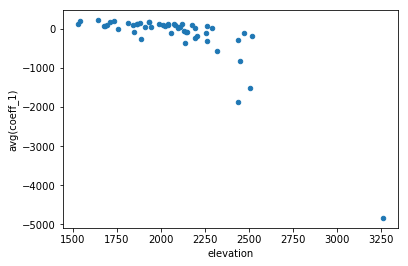

In [13]:
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');